In [1]:
import os
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from glob import glob
from skimage.io import imread
from os import listdir
from sklearn.preprocessing import LabelEncoder
import time
import cv2
import copy
from random import shuffle
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.metrics import sensitivity_specificity_support
from imgaug import augmenters as iaa
import imgaug as ia
import tensorflow as tf

# import numpy as np
# import matplotlib.pyplot as plt
from itertools import cycle

# from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD,Adam
import numpy as np

# from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,concatenate
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard,CSVLogger
# import tools
import gc
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix
from keras.models import Model
import keras
# import channel_attention

In [2]:
folder = os.listdir("../input/lung-colon-normal/trainable_normal")
print(folder)

['colon_aca', 'lung_aca', 'lung_scc', 'colon_n', 'lung_n']


In [3]:
base_path = "../input/lung-colon-normal/trainable_normal"
total_images = 0
image_class =[]
for n in range(len(folder)):
  image_path = os.path.join(base_path, folder[n]) 
  print(image_path)
  # class_path = patient_path + "/" + str(c) + "/"
  subfiles = os.listdir(image_path)
  print(len(subfiles))
  image_class.append(len(subfiles))
  total_images += len(subfiles)
print("The number of total images are:{}".format(total_images))  
print(image_class)

../input/lung-colon-normal/trainable_normal/colon_aca
5000
../input/lung-colon-normal/trainable_normal/lung_aca
5000
../input/lung-colon-normal/trainable_normal/lung_scc
5000
../input/lung-colon-normal/trainable_normal/colon_n
5000
../input/lung-colon-normal/trainable_normal/lung_n
5000
The number of total images are:25000
[5000, 5000, 5000, 5000, 5000]


In [4]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["path", "target"])

k = 0
for n in range(len(folder)):
    class_id = folder[n]
    final_path = os.path.join(base_path,class_id) 
    subfiles = os.listdir(final_path)
    for m in range(len(subfiles)):
      image_path = subfiles[m]
      data.iloc[k]["path"] = os.path.join(final_path,image_path)
      data.iloc[k]["target"] = class_id
      k += 1  

data.head()

,path,target
0,../input/lung-colon-normal/trainable_normal/co...,colon_aca
1,../input/lung-colon-normal/trainable_normal/co...,colon_aca
2,../input/lung-colon-normal/trainable_normal/co...,colon_aca
3,../input/lung-colon-normal/trainable_normal/co...,colon_aca
4,../input/lung-colon-normal/trainable_normal/co...,colon_aca


In [5]:
data['target'].unique()

array(['colon_aca', 'lung_aca', 'lung_scc', 'colon_n', 'lung_n'],
      dtype=object)

In [6]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data['target_label'] = labelencoder.fit_transform(data['target'])
data = data.sample(frac=1).reset_index(drop=True)
data

,path,target,target_label
0,../input/lung-colon-normal/trainable_normal/lu...,lung_n,3
1,../input/lung-colon-normal/trainable_normal/lu...,lung_scc,4
2,../input/lung-colon-normal/trainable_normal/co...,colon_n,1
3,../input/lung-colon-normal/trainable_normal/lu...,lung_scc,4
4,../input/lung-colon-normal/trainable_normal/lu...,lung_scc,4
...,...,...,...
24995,../input/lung-colon-normal/trainable_normal/lu...,lung_scc,4
24996,../input/lung-colon-normal/trainable_normal/lu...,lung_n,3
24997,../input/lung-colon-normal/trainable_normal/co...,colon_aca,0
24998,../input/lung-colon-normal/trainable_normal/co...,colon_n,1


In [7]:
data.iloc[1000,:]

path            ../input/lung-colon-normal/trainable_normal/lu...
target                                                   lung_aca
target_label                                                    2
Name: 1000, dtype: object

In [8]:
data.groupby("target_label").size()

target_label
0    5000
1    5000
2    5000
3    5000
4    5000
dtype: int64

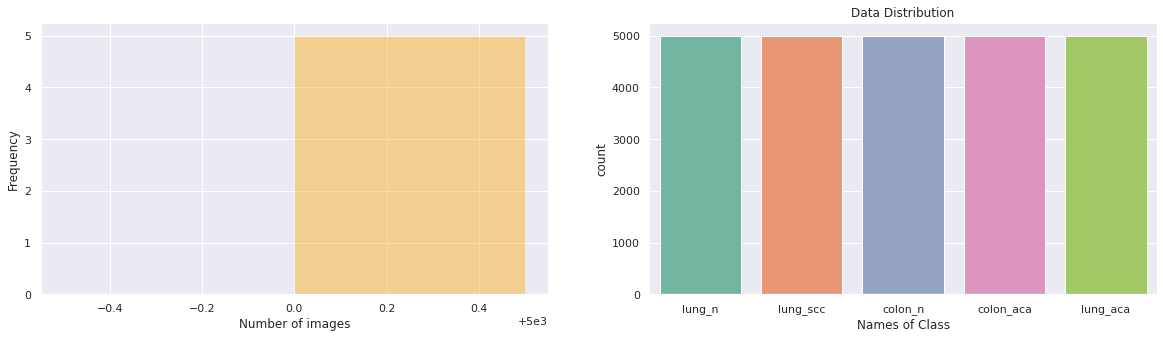

In [9]:
# cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
# cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.groupby("target_label").size(), ax=ax[0], color="Orange", kde=False)
ax[0].set_xlabel("Number of images")
ax[0].set_ylabel("Frequency");

sns.countplot(data.target, palette="Set2", ax=ax[1]);
ax[1].set_xlabel("Names of Class")
ax[1].set_title("Data Distribution");

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   path          25000 non-null  object
 1   target        25000 non-null  object
 2   target_label  25000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [11]:
data.describe()

,target_label
count,25000.000000
mean,2.000000
std,1.414242
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


In [12]:
data.target_label

0        3
1        4
2        1
3        4
4        4
        ..
24995    4
24996    3
24997    0
24998    1
24999    3
Name: target_label, Length: 25000, dtype: int64

In [13]:
X = data.path
y = data.target_label
X_train, X_test_sub ,y_train,y_test_sub= train_test_split(X,y, test_size=0.3, random_state=0,shuffle = True)
print(X_train.shape)
print(X_test_sub.shape)

(17500,)
(7500,)


In [14]:
X_test,X_valid,y_test,y_valid = train_test_split(X_test_sub, y_test_sub, test_size=0.5, random_state=0 , shuffle =False)
print(X_test.shape)
print(X_valid.shape)

(3750,)
(3750,)


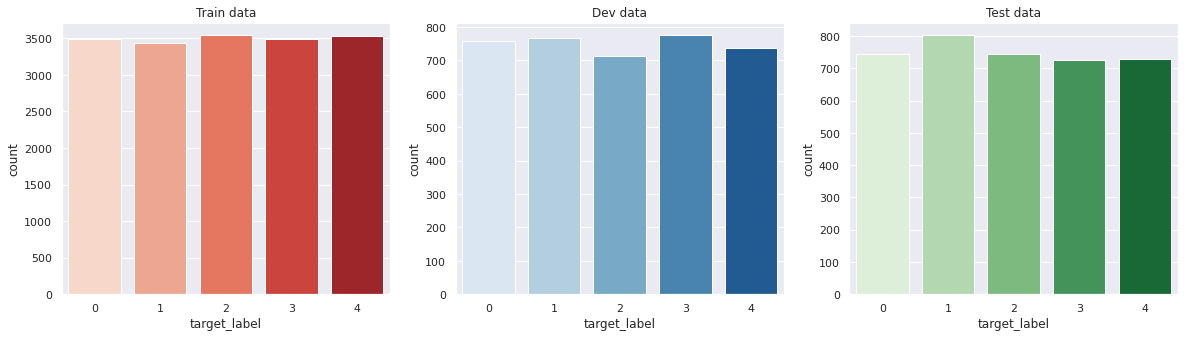

In [15]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.countplot(y_train, ax=ax[0], palette="Reds")
ax[0].set_title("Train data")
sns.countplot(y_valid, ax=ax[1], palette="Blues")
ax[1].set_title("Dev data")
sns.countplot(y_test, ax=ax[2], palette="Greens");
ax[2].set_title("Test data");

In [16]:
data.path.values

array(['../input/lung-colon-normal/trainable_normal/lung_n/lungn3953.jpeg',
       '../input/lung-colon-normal/trainable_normal/lung_scc/lungscc2285.jpeg',
       '../input/lung-colon-normal/trainable_normal/colon_n/colonn1251.jpeg',
       ...,
       '../input/lung-colon-normal/trainable_normal/colon_aca/colonca4646.jpeg',
       '../input/lung-colon-normal/trainable_normal/colon_n/colonn4691.jpeg',
       '../input/lung-colon-normal/trainable_normal/lung_n/lungn4679.jpeg'],
      dtype=object)

In [17]:
target_label_map = {k:v for k,v in zip(data.path.values,data.target_label.values)}

In [18]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, target_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        # shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.resize(cv2.imread(x),(224,224),interpolation=cv2.INTER_CUBIC) for x in batch]
            # for x in X:
            #   X.append(cv2.resize(x,(224,224),interpolation=cv2.INTER_CUBIC))
            # X = [cv2.resize(x,(224,224,3)) for x in X]
            Y = [target_label_map[x] for x in batch]
            # print(Y)
            Y = to_categorical(Y, num_classes = 5)
            # print(Y)
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)
    

In [19]:
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0009)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

input_tensor = Input(shape=(224,224, 3))
#backbone

base_model = tf.keras.applications.ResNet50(input_tensor= input_tensor, weights='imagenet', include_top=False)
base_output = base_model.output
print(base_output.shape)
# channel-attention
# x = squeeze_excitation_layer(base_output, 2048, ratio=4, concate=False)
# x = BatchNormalization()(x)

# #concat
# x = concatenate([base_output, x], axis=3)
# spp

gap = GlobalAveragePooling2D()(base_output)
x = Flatten()(base_output)
x = concatenate([gap,x])
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predict = Dense(5, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predict)

for layer in (base_model.layers):
    layer.trainable = False

# for l in model.layers:
#   print(l.name)

94773248/94765736 [==============================] - 1s 0us/step
(None, 7, 7, 2048)


In [20]:
model.compile(optimizer=adam,
              
                  loss='categorical_crossentropy',
                  metrics=[keras.metrics.categorical_accuracy])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [21]:
!pip install ipython-autotime
 
%load_ext autotime

time: 650 µs


In [22]:
batch_size=32
history = model.fit_generator(
    data_gen(X_train, target_label_map, batch_size, augment=True),
    validation_data=data_gen(X_valid, target_label_map, batch_size),
    epochs=50, 
    verbose = 1,
    #callbacks=callbacks,
    steps_per_epoch=  int(len(X_train)//batch_size),
    validation_steps= int(len(X_valid)// batch_size)
)

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_de

Epoch 1/50
546/546 [==============================] - 481s 881ms/step - loss: 0.4297 - categorical_accuracy: 0.8480 - val_loss: 0.0588 - val_categorical_accuracy: 0.9768
Epoch 2/50
546/546 [==============================] - 419s 767ms/step - loss: 0.2522 - categorical_accuracy: 0.9018 - val_loss: 0.0472 - val_categorical_accuracy: 0.9834
Epoch 3/50
546/546 [==============================] - 417s 763ms/step - loss: 0.2127 - categorical_accuracy: 0.9174 - val_loss: 0.0390 - val_categorical_accuracy: 0.9861
Epoch 4/50
546/546 [==============================] - 420s 770ms/step - loss: 0.2003 - categorical_accuracy: 0.9210 - val_loss: 0.0244 - val_categorical_accuracy: 0.9912
Epoch 5/50
546/546 [==============================] - 420s 770ms/step - loss: 0.1872 - categorical_accuracy: 0.9262 - val_loss: 0.0240 - val_categorical_accuracy: 0.9912
Epoch 6/50
546/546 [==============================] - 419s 767ms/step - loss: 0.1688 - categorical_accuracy: 0.9355 - val_loss: 0.0261 - val_categoric

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model

filepath = './'

time: 784 µs


In [24]:
tf.keras.models.save_model(
    model,
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

time: 29.2 s


def data_gen1(list_files, target_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        # shuffle(list_files)
        for batch in chunker(list_files, batch_size):
          X = [cv2.resize(cv2.imread(x),(224,224),interpolation=cv2.INTER_CUBIC) for x in batch]
            # for x in X:
            #   X.append(cv2.resize(x,(224,224),interpolation=cv2.INTER_CUBIC))
            # X = [cv2.resize(x,(224,224,3)) for x in X]
          Y = [target_label_map[x] for x in batch]
            # print(Y)
          Y = to_categorical(Y, num_classes = 5)
            # print(Y)
          if augment:
            X = seq.augment_images(X)
          X = [preprocess_input(x) for x in X]
                
          return np.array(X), np.array(Y)

p1 ,p2 = data_gen1(X_valid,target_label_map,3750) 
score = model.evaluate(p1,p2, verbose=0)
print('Model Accuracy:', score[1],'\n')

# def plot_learning_curve(history):
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
    # plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('./loss_curve.png')

X_test_final,y_test_final = data_gen1(X_test,target_label_map,3500)
print(y_test_final.shape) 
y_pred = model.predict(X_test_final)
print(y_pred.shape)
Y_pred_classes = np.argmax(y_pred,axis=1) 
print(Y_pred_classes.shape)
Y_true = np.argmax(y_test_final,axis=1)
print(Y_true.shape) 


def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

cm = confusion_matrix(Y_true, Y_pred_classes)

print(cm)


clssrep = classification_report(Y_true, Y_pred_classes)
    # CLssrep.append(clssrep)
print(clssrep)


df_cm = pd.DataFrame(cm, index = folder, columns= folder )
fig = plt.figure(figsize = (10,7))

heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize= 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize= 14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

classification_accuracy = accuracy(cm)
print("Classification Accuracy:{0:0.6f}".format(classification_accuracy))

[Precision,Sensitivity,F1_score,_] = precision_recall_fscore_support(Y_true, Y_pred_classes, average='weighted')
[_, Specificity,_] = sensitivity_specificity_support(Y_true, Y_pred_classes, average='weighted')



    
print('Precision : {0:0.6f}'.format(Precision))
print('Sensitivity : {0:0.6f}'.format(Sensitivity))
print('Specificity : {0:0.6f}'.format(Specificity))
print('F1_score : {0:0.6f}'.format(F1_score))

y_test = to_categorical(Y_true, num_classes = 5)
y_pred = to_categorical(Y_pred_classes ,num_classes =5)
# print(y_test)
# print(y_pred)
n_classes =5

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # print(roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize =(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
